<a href="https://colab.research.google.com/github/liushui1986/ALS_drug_identifier/blob/master/drug_identifier_deep_learning_pytorch_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%pip install git+https://github.com/EBjerrum/molvecgen

  Cloning https://github.com/EBjerrum/molvecgen to /tmp/pip-req-build-0v_on3jl
  Running command git clone --filter=blob:none --quiet https://github.com/EBjerrum/molvecgen /tmp/pip-req-build-0v_on3jl
  Resolved https://github.com/EBjerrum/molvecgen to commit f81d5aade18bea60882f5845877f6283366bbe91
  Preparing metadata (setup.py) ... done
  Created wheel for molvecgen: filename=molvecgen-0.1-py3-none-any.whl size=11357 sha256=e53a8536171424915c353c042092517d5b70db174b93b0b4bd54f916fd4f170f
  Stored in directory: /tmp/pip-ephem-wheel-cache-qnmeebbr/wheels/1c/de/14/fd9892b48271e63e56b00c7015c754ae6189e258fa313a7c63
Successfully built molvecgen


In [4]:
%pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 31.1 MB/s eta 0:00:00


In [104]:
import numpy as np
import pandas as pd
import io
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [7]:
from google.colab import files

uploaded = files.upload()

Saving small_molecules_smiles_only_05222024_sm.csv to small_molecules_smiles_only_05222024_sm.csv


In [8]:
df = pd.read_csv(io.BytesIO(uploaded['small_molecules_smiles_only_05222024_sm.csv']))

In [9]:
df.head()

,good,canon_smiles
0,0,CC1(C)CCC(c2ccc(Cl)cc2)=C(CN2CCN(c3ccc(C(=O)NS...
1,0,CN(C)CC[C@H](CSc1ccccc1)Nc1ccc(S(=O)(=O)NC(=O)...
2,0,Cc1ccc(F)c(NC(=O)Nc2ccc(-c3cccc4[nH]nc(N)c34)c...
3,0,C[C@@]1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1
4,0,CNC(=O)c1ccccc1Sc1ccc2c(/C=C/c3ccccn3)n[nH]c2c1


In [10]:
PandasTools.AddMoleculeColumnToFrame(df, 'canon_smiles', 'Molecule')
df.head()

[16:13:52] WARNING: not removing hydrogen atom without neighbors
[16:13:52] WARNING: not removing hydrogen atom without neighbors


,good,canon_smiles,Molecule
0,0,CC1(C)CCC(c2ccc(Cl)cc2)=C(CN2CCN(c3ccc(C(=O)NS...,<rdkit.Chem.rdchem.Mol object at 0x7c154af715b0>
1,0,CN(C)CC[C@H](CSc1ccccc1)Nc1ccc(S(=O)(=O)NC(=O)...,<rdkit.Chem.rdchem.Mol object at 0x7c154af71a10>
2,0,Cc1ccc(F)c(NC(=O)Nc2ccc(-c3cccc4[nH]nc(N)c34)c...,<rdkit.Chem.rdchem.Mol object at 0x7c154af72420>
3,0,C[C@@]1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1,<rdkit.Chem.rdchem.Mol object at 0x7c154af735a0>
4,0,CNC(=O)c1ccccc1Sc1ccc2c(/C=C/c3ccccn3)n[nH]c2c1,<rdkit.Chem.rdchem.Mol object at 0x7c154af70c80>


In [11]:
from molvecgen.vectorizers import SmilesVectorizer

In [12]:
smivec = SmilesVectorizer(pad=1, leftpad=True, canonical=False, augment=True)
smivec.fit(df.Molecule.values, )

In [13]:
df['Molecule'].values

array([<rdkit.Chem.rdchem.Mol object at 0x7c154af715b0>,
       <rdkit.Chem.rdchem.Mol object at 0x7c154af72420>, ...,
       <rdkit.Chem.rdchem.Mol object at 0x7c154a8c5e70>], dtype=object)

In [14]:
print(smivec.charset)
smivec.dims

[K(2]@Nl=S-1\Oa7sM#3FH.t5nu6IZ4rRcBe)+oCP/^$?


(275, 45)

In [15]:
y = df['good'].values
X = df.Molecule.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=42)

In [17]:
"""
PyTorch works with datasets, and we can easily integrate the vectorizer by subclassing the __getitem__ method and the __len__ method.
This way we can load the dataset with RDKit molecular objects and generate the tensors on the fly. This allows us to use SMILES augmentation
on the fly without pre vectorizing the dataset. This is a small overhead during training, but it is convenient and allows to handle huge datasets
without running out of memory.
"""

'\nPyTorch works with datasets, and we can easily integrate the vectorizer by subclassing the __getitem__ method and the __len__ method.\nThis way we can load the dataset with RDKit molecular objects and generate the tensors on the fly. This allows us to use SMILES augmentation\non the fly without pre vectorizing the dataset. This is a small overhead during training, but it is convenient and allows to handle huge datasets\nwithout running out of memory.\n'

In [18]:
# Wrapping the SMILES vectorizer in a PyTorch dataset

class SMILESMolDataset(Dataset):
  def __init__(self, molecules, y, vectorizer):
    self.molecules = molecules
    self.y = y
    self.vectorizer = vectorizer
  def __len__(self):
    return len(self.molecules)
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    mols = self.molecules[idx]

    # The vectorizer was written to work with batches,
    # but PyTorch datasets unfortunately works with single sample
    sample = self.vectorizer.transform([mols])[0]
    label = self.y[idx]
    return sample, label

In [19]:
train_dataset = SMILESMolDataset(X_train, y_train, smivec)


In [20]:
train_dataset[0]

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0]], dtype=int8),
 0)

In [21]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
X_val_t = smivec.transform(X_val, canonical=False)
X_val_t = torch.tensor(X_val_t, device=device).float()
y_val_t = torch.tensor(y_val, device=device).float()
X_val_t.shape

cuda:0


torch.Size([270, 275, 45])

In [83]:
# Define the PyTorch LSTM molecular model
# Here we will define the neural network architecture.
# I'll keep this pretty simple with only one single layer of LSTM cells and a bit of dropout for conteraction overfitting.

class Net(nn.Module):
  def __init__(self, dimensions, lstm_size, hidden_size, dropout_rate, out_size=1):
    super(Net, self).__init__()

    length = dimensions[0]
    number_tokens = dimensions[1]

    # Define LSTM layer
    self.lstm = nn.LSTM(input_size=number_tokens, hidden_size=lstm_size, num_layers=1, batch_first=True)

    # Define fully connected layers
    self.fc1 = nn.Linear(lstm_size, hidden_size)  # Hidden layer
    self.activation = nn.ReLU() # Activation function for hidden layer
    self.fc_out = nn.Linear(hidden_size, out_size) # Output layer with one unit for binary classification

    # Define dropout layer
    self.dropout = nn.Dropout(dropout_rate)

  def forward(self, x): # Forward pass: stacking each layer together
    #LSTM network reads in one-hot-encoded SMILES
    out, (h_n, c_n) = self.lstm(x)

    # Use the last hidden state from the LSTM
    out = h_n[-1]

    # Apply dropout
    out = self.dropout(out)

    # Pass through the hidder layer and activation function
    out = self.fc1(out)
    out = self.activation(out)

    # Apply dropout
    out = self.dropout(out)

    # Final output layer(for binary classification)
    out = self.fc_out(out)

    return out

In [84]:
epochs = 250  # I can implement early stopping to halt training when the validation loss stops improving.
dims = smivec.dims  # This is necessary to define the input dimensions. Ensure 'smivec.dims' returns the correct shape: '[sequence_length, number_tokens]'.
lstm_size = 64  # The size of the LSTM hidden state. I may experiment with larger size (e.g., 256 or 512) if necessary.
hidden_size = 128  # This number is a typical one. I'll adjust it based on the model's performance
dropout_rate = 0.70  # A dropout rate of 0.5 is standard for preventing overfitting. I may reduce it to 0.3 if underfitting occurs.
output_size = 1  # This is for binary classification, as the output is a single probability value.
batch_size = 32  # A batch size of 128 is commonly used and generally effective. Depending on GPU memory, I may try different sizes (e.g., 64 or 256).
learning_rate = 0.001  # If the training is unstable, I'll lower it to 0.001.

In [85]:
model = Net(dims, lstm_size, hidden_size, dropout_rate, output_size)
model.cuda() # Move the model to GPU

Net(
  (lstm): LSTM(45, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (activation): ReLU()
  (fc_out): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.7, inplace=False)
)

In [86]:
pred = model.forward(X_val_t[10:11])
pred

tensor([[-0.0598]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [87]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50, verbose=True,
                                 threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-6, eps=1e-08)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [88]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [89]:
for smiles, labels in train_loader:
  break

In [90]:
# Check the current device
print(device)

cuda:0


In [91]:
train_losses = []
validation_losses = []

# Define early stopping parameters
early_stopping_patience = 10
best_val_loss = float('inf')
epochs_without_improvement = 0

In [92]:
for epoch in range(epochs):
  running_loss = 0
  model.train()
  for i, (smiles, labels) in enumerate(train_loader):
    # Push tensors to CUDA tensors
    smiles = torch.tensor(smiles, device=device).float()
    labels = torch.tensor(labels, device=device).float()

    # Clear previous gradients
    optimizer.zero_grad()
    # Forward pass
    output = model(smiles).squeeze()
    # Compute loss
    loss = criterion(output, labels)
    # Backward pass
    loss.backward()
    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
    # Update weights
    optimizer.step()

    running_loss += loss.item()

    # Gradient accumulation
    if (i + 1) % 4 == 0:
      optimizer.step()
      optimizer.zero_grad()


  # Validation step
  # Set model to evaluation mode
  model.eval()
  val_loss = torch.mean((y_val_t - model(X_val_t))**2)

  # Switch back to training mode
  model.train()

  # Learning rate scheduler step
  lr_scheduler.step(val_loss)

  # Calculate and store losses
  train_loss = running_loss / len(train_loader)
  train_losses.append(train_loss)
  validation_losses.append(val_loss)

  # Check for early stopping
  if val_loss < best_val_loss:
    best_val_loss = val_loss
    epochs_without_improvement = 0
    # Save model checkpoint if necessary
    torch.save(model.state_dict(), 'best_model.pth')
  else:
    epochs_without_improvement += 1

  if epochs_without_improvement >= early_stopping_patience:
    print(f'Early stopping at epoch {epoch + 1}')
    break

  if (epoch + 1) % 10 == 0:
    print(f'Epoch {epoch+1}, Training loss: {train_loss:.2f}, Validation loss: {val_loss:.2f}')

  # Clear cache after each epoch
  torch.cuda.empty_cache()

<ipython-input-92-ab70a4b41c39>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  smiles = torch.tensor(smiles, device=device).float()
<ipython-input-92-ab70a4b41c39>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, device=device).float()


Epoch 10, Training loss: 0.13, Validation loss: 15.41
Epoch 20, Training loss: 0.13, Validation loss: 18.58
Early stopping at epoch 28


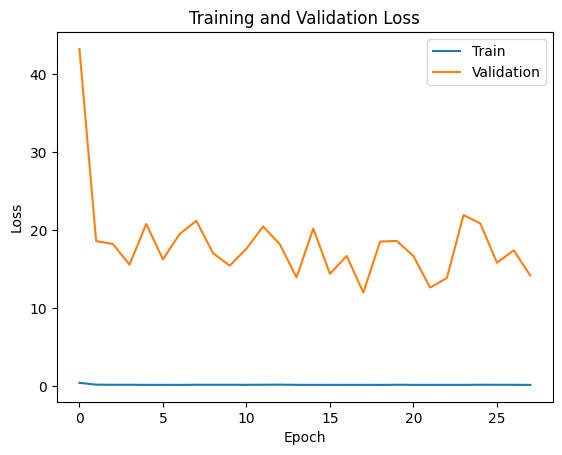

In [93]:
train_losses = [float(x) for x in train_losses]
validation_losses = [float(x) for x in validation_losses]

plt.plot(train_losses, label="Train")
plt.plot(validation_losses, label="Validation")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [95]:
# Vectorize the train and test sets and see how they perform
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
X_train_t = smivec.transform(X_train, canonical=False)
X_train_t = torch.tensor(X_train_t, device=device).float()
y_train_t = torch.tensor(y_train, device=device).float()
X_train_t.shape

cuda:0


torch.Size([1080, 275, 45])

In [96]:
# Vectorize the train and test sets and see how they perform
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
X_test_t = smivec.transform(X_test, canonical=False)
X_test_t = torch.tensor(X_test_t, device=device).float()
y_test_t = torch.tensor(y_test, device=device).float()
X_test_t.shape

cuda:0


torch.Size([579, 275, 45])

In [100]:
# Evaluating the performance

model.eval()
with torch.no_grad():
  y_pred_train = model(X_train_t)
  y_pred_val = model(X_val_t)
  y_pred_test = model(X_test_t)

In [101]:
# Convert predictions to NumPy arrays
y_pred_train_np = y_pred_train.cpu().numpy()
y_pred_val_np = y_pred_val.cpu().numpy()
y_pred_test_np = y_pred_test.cpu().numpy()

In [102]:
# Replace with your true labels for training
y_train_true = np.array(y_train)
y_val_true = np.array(y_val)
y_test_true = np.array(y_test)

In [103]:
# Binarize the predications
y_pred_train_bin = (y_pred_train_np > 0.5).astype(int)
y_pred_val_bin = (y_pred_val_np > 0.5).astype(int)
y_pred_test_bin = (y_pred_test_np > 0.5).astype(int)

In [105]:
# Calculate performance metrics
train_accuracy = accuracy_score(y_train_true, y_pred_train_bin)
val_accuracy = accuracy_score(y_val_true, y_pred_val_bin)
test_accuracy = accuracy_score(y_test_true, y_pred_test_bin)

train_precision = precision_score(y_train_true, y_pred_train_bin)
val_precision = precision_score(y_val_true, y_pred_val_bin)
test_precision = precision_score(y_test_true, y_pred_test_bin)

train_recall = recall_score(y_train_true, y_pred_train_bin)
val_recall = recall_score(y_val_true, y_pred_val_bin)
test_recall = recall_score(y_test_true, y_pred_test_bin)

train_f1 = f1_score(y_train_true, y_pred_train_bin)
val_f1 = f1_score(y_val_true, y_pred_val_bin)
test_f1 = f1_score(y_test_true, y_pred_test_bin)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [106]:
print("Train Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)
print("Test Accuracy:", test_accuracy)

print("Train Precision:", train_precision)
print("Validation Precision:", val_precision)
print("Test Precision:", test_precision)

print("Train Recall:", train_recall)
print("Validation Recall:", val_recall)
print("Test Recall:", test_recall)

print("Train F1 Score:", train_f1)
print("Validation F1 Score:", val_f1)
print("Test F1 Score:", test_f1)

Train Accuracy: 0.9768518518518519
Validation Accuracy: 0.9814814814814815
Test Accuracy: 0.9723661485319517
Train Precision: 0.0
Validation Precision: 0.0
Test Precision: 0.0
Train Recall: 0.0
Validation Recall: 0.0
Test Recall: 0.0
Train F1 Score: 0.0
Validation F1 Score: 0.0
Test F1 Score: 0.0


In [107]:
# Severe overfitting and no predictions for positive drug group